In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
from scipy.stats import skew,boxcox_normmax, zscore
from scipy.special import boxcox1p
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,RobustScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error 
from mlxtend.regressor import StackingCVRegressor
from multiprocessing import cpu_count
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,StackingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
import xgboost as xgb
from sklearn.svm import SVR




Importation des datasets:

In [4]:
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")

NameError: name 'pd' is not defined

On compte le nombre de valeurs manquantes pour les variables numériques

In [ ]:
null_counts=train_df.isnull().sum()
null_columns = null_counts[null_counts > 0]
null_columns2 = null_columns.drop(["Alley","MasVnrType","MasVnrArea","GarageYrBlt","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"])

print(null_columns2)

NameError: name 'train_df' is not defined

On concatène les datasets pour effectuer les modifications sur le set de test et d'entraînement en même temps.

In [ ]:
data = pd.concat([train_df.drop("SalePrice",axis=1),test_df]) #Drop la variable cible


On affiche graphiquement le nombre de valeurs manquantes

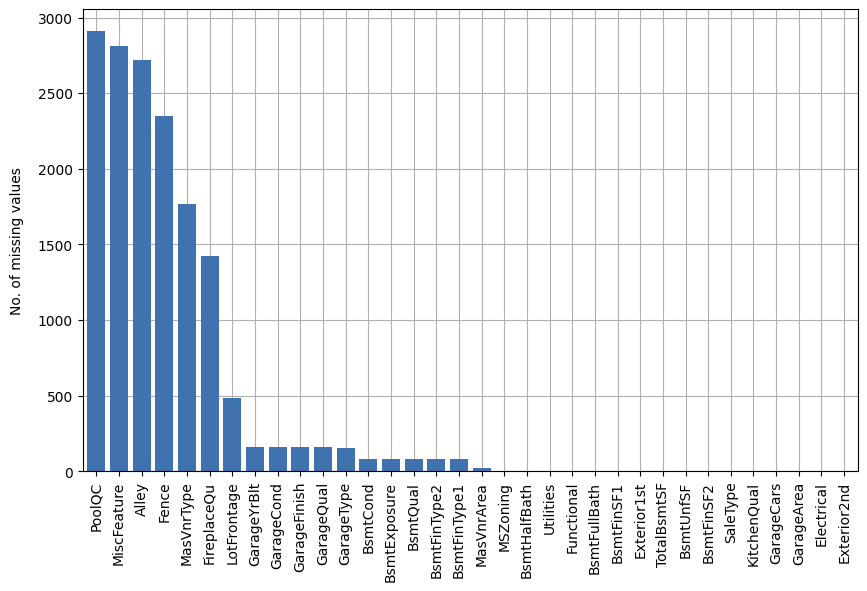

In [6]:
nans = data.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

Passage de la variable cible au logarithme pour normaliser les valeurs: 

In [3]:
y1 = train_df['SalePrice']
sns.histplot(y1, kde=True, bins=30, color="blue")
plt.axvline(y1.mean(), color='red', linestyle='dashed', linewidth=2, label="Moyenne")
plt.axvline(y1.median(), color='green', linestyle='dashed', linewidth=2, label="Médiane")
plt.legend()
plt.show()

NameError: name 'train_df' is not defined

Transformation logarithmique pour avoir des résidus qui suivent une loi normale => meilleur modèle

In [ ]:
y = np.log(train_df["SalePrice"]) #Passage au logarithme

Histogramme après le passage au logarithme

In [ ]:
sns.histplot(y, kde=True, bins=30, color="blue")
plt.axvline(y.mean(), color='red', linestyle='dashed', linewidth=2, label="Moyenne")
plt.axvline(np.median(y), color='green', linestyle='dashed', linewidth=2, label="Médiane")
plt.legend()
plt.show()


In [ ]:
train_df_numeric = train_df.select_dtypes(include=[np.number]) #Conserve que les valeurs numériques pour afficher la matrice de corrélation
train_df_numeric = train_df_numeric.drop(columns=["Id"])

In [10]:
train_df_numeric.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Matrice de corrélation

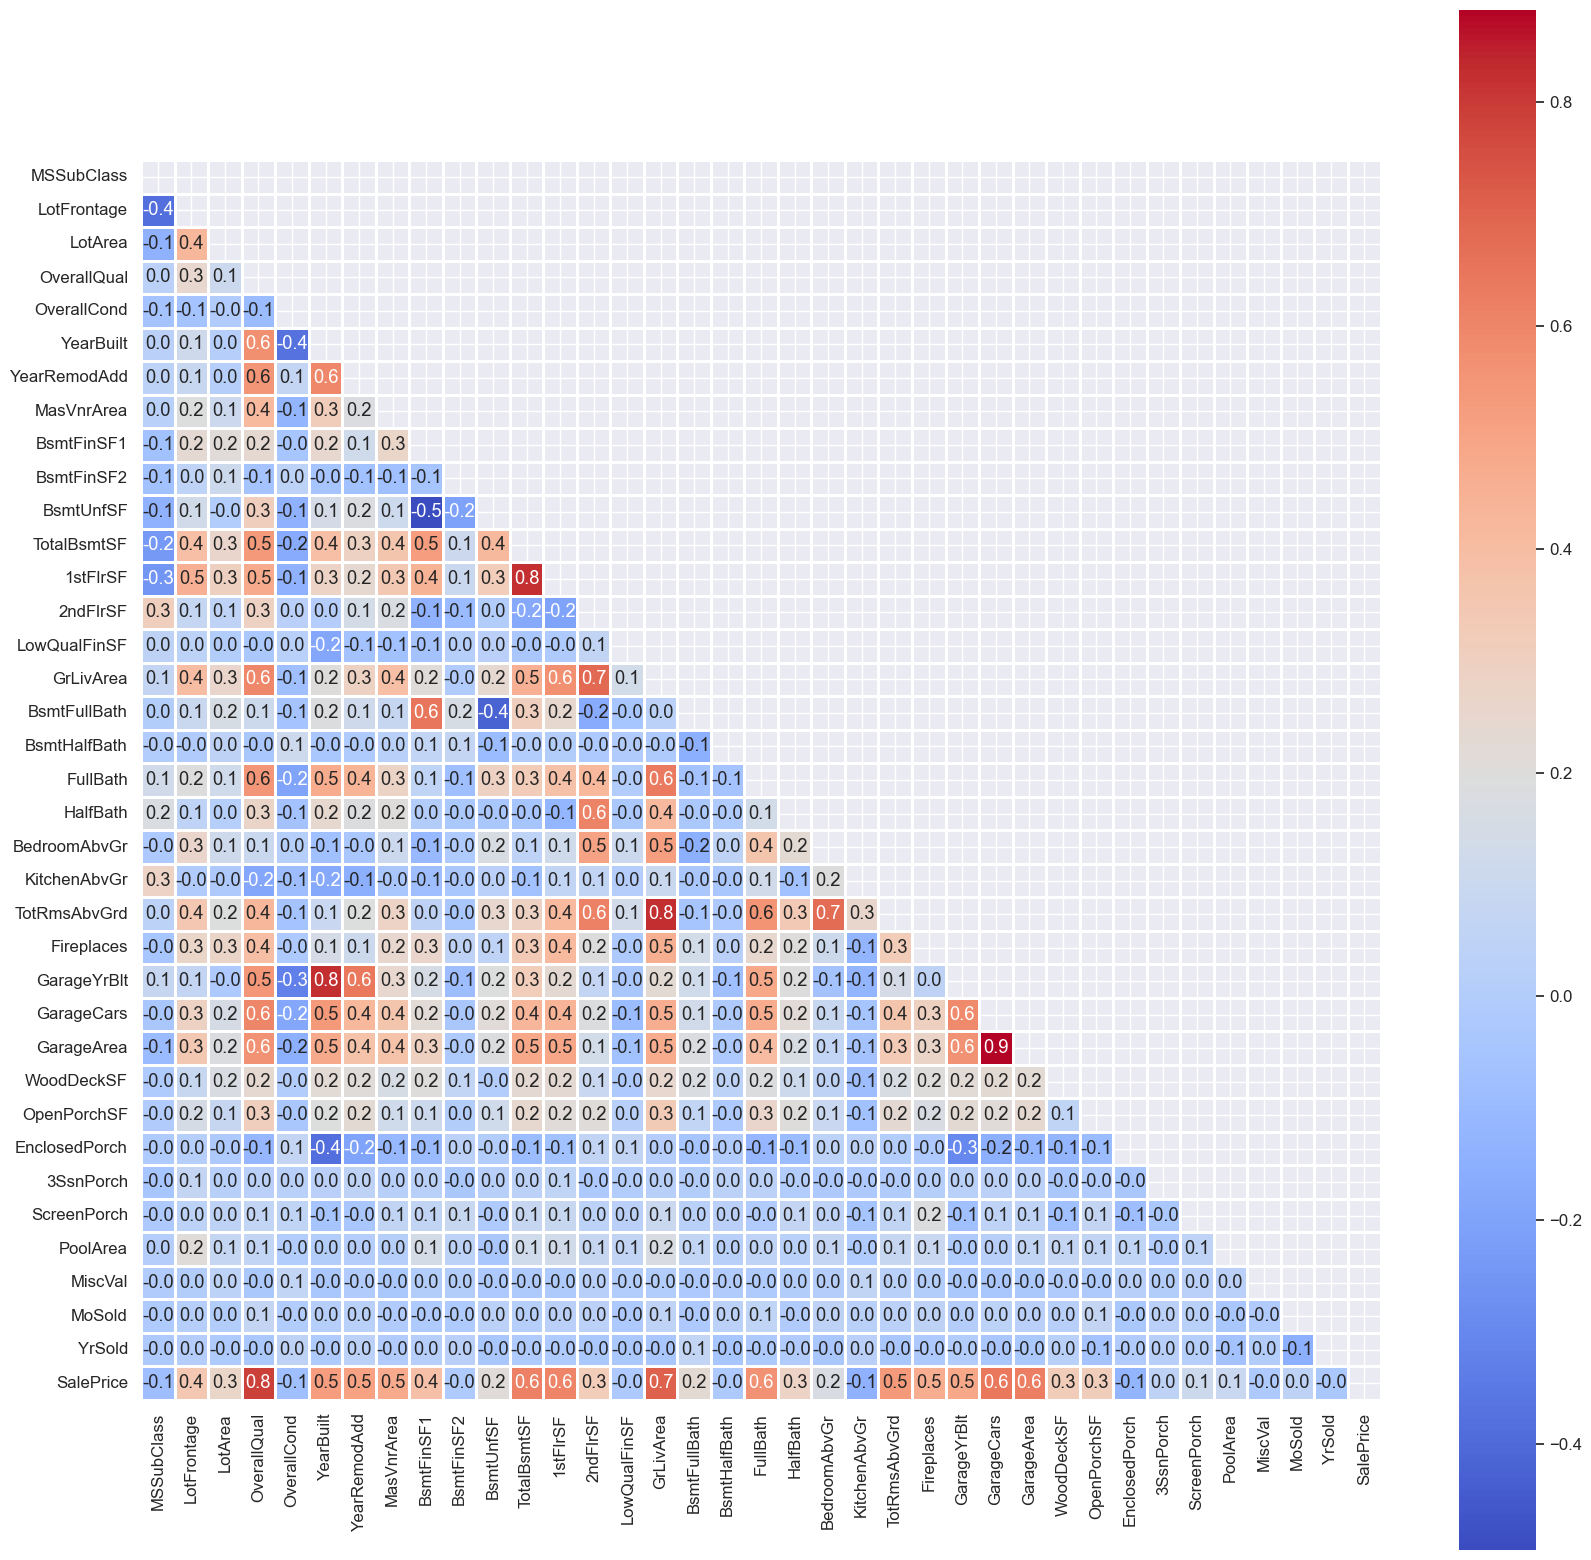

In [11]:
sns.set(font_scale=1.1)
corr_train = train_df_numeric.corr()
mask = np.triu(corr_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(corr_train, annot=True, fmt='.1f', cmap='coolwarm', square=True, mask=mask, linewidth=1, cbar=True)
plt.show()

In [13]:
null_counts=data.isna().sum()
null_column = null_counts[null_counts > 0]

categorical_NA=["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

null_column = null_column.drop(categorical_NA)

#print(null_column)
null_columns=["MasVnrType", "MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual", "Functional"]
na_numerical=null_column.drop(null_columns)
print(na_numerical)


LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64


On remplace les NA des valeurs catégoriques par None pour pas induire en erreur les algorithmes

In [14]:
data[categorical_NA]=data[categorical_NA].fillna("None")

On rempli avec le mode le plus présent par quartiers pour chaque valeur manquante

In [ ]:
data[null_columns] = data.groupby("Neighborhood")[null_columns].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x) #Mode permet de remplir avec la valeur la plus présente parmis les quartiers identiques
) 

C:\Users\polka\AppData\Local\Temp\ipykernel_3956\706237936.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x)


Maintenant on va travailler sur les valeurs numériques manquantes
LotFrontage=> 17.7% de valeurs manquantes -> pas besoin de KNN juste mettre la médiane par quartiers suffit
GarageArea idem

In [16]:
numerical_median=["LotFrontage","GarageYrBlt"]
data[numerical_median] = data.groupby("Neighborhood")[numerical_median].transform(lambda x: x.fillna(x.median())) 


Très peu de valeurs manquantes => on met directement la valeur à 0

In [17]:
features_zerofill = ["GarageArea", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
data[features_zerofill] = data[features_zerofill].fillna(0)

On créé de nouvelles colonnes pour avoir des infos plus significatives

ICi on aura le nombre total

In [ ]:
data["TotalArea"] = data["GrLivArea"] + data["TotalBsmtSF"] #Surface totale
data["TotalBaths"] = data["FullBath"] + data["BsmtFullBath"] + 0.5*(data["HalfBath"]+data["BsmtHalfBath"]) #Nombre total de salles de bain
data["TotalPorch"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"] #Nombre total de porche

ICi on note la présence ou non de certains éléments

In [ ]:
data['Pool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0) #Présence d'une piscine
data['MasVnr'] = data['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0) #Présence de placage
data['Basement'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) #Présence d'un sous-sol
data['Garage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) #Présence d'un garage
data['2ndFloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) #Présence d'un 2nd étage
data['Porch'] = data['TotalPorch'].apply(lambda x: 1 if x > 0 else 0) #Présence d'un porche
data['Fireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) #Présence d'une cheminée


On remarque que MSSubClass et YrSold sont en fait des variables catégoriques, on doit donc les changer en type catégorique

In [21]:
data[["YrSold","MSSubClass"]]=data[["YrSold","MSSubClass"]].astype("category")

Valeurs cycliques à traiter
MoSold_sin=sin(2π×MoSold/12)
MoSold_ cos=cos(2π×MoSold/12)

In [ ]:
data["MoSoldsin"] = np.sin(2 * np.pi * data["MoSold"] / 12) 
data["MoSoldcos"] = np.cos(2 * np.pi * data["MoSold"] / 12) #Ajout de 2 nouvelles colonnes
data = data.drop("MoSold", axis=1) #On enlève MoSold

Observons la distribution de nos variables

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>],
       [<Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'BedroomAbvGr'}>

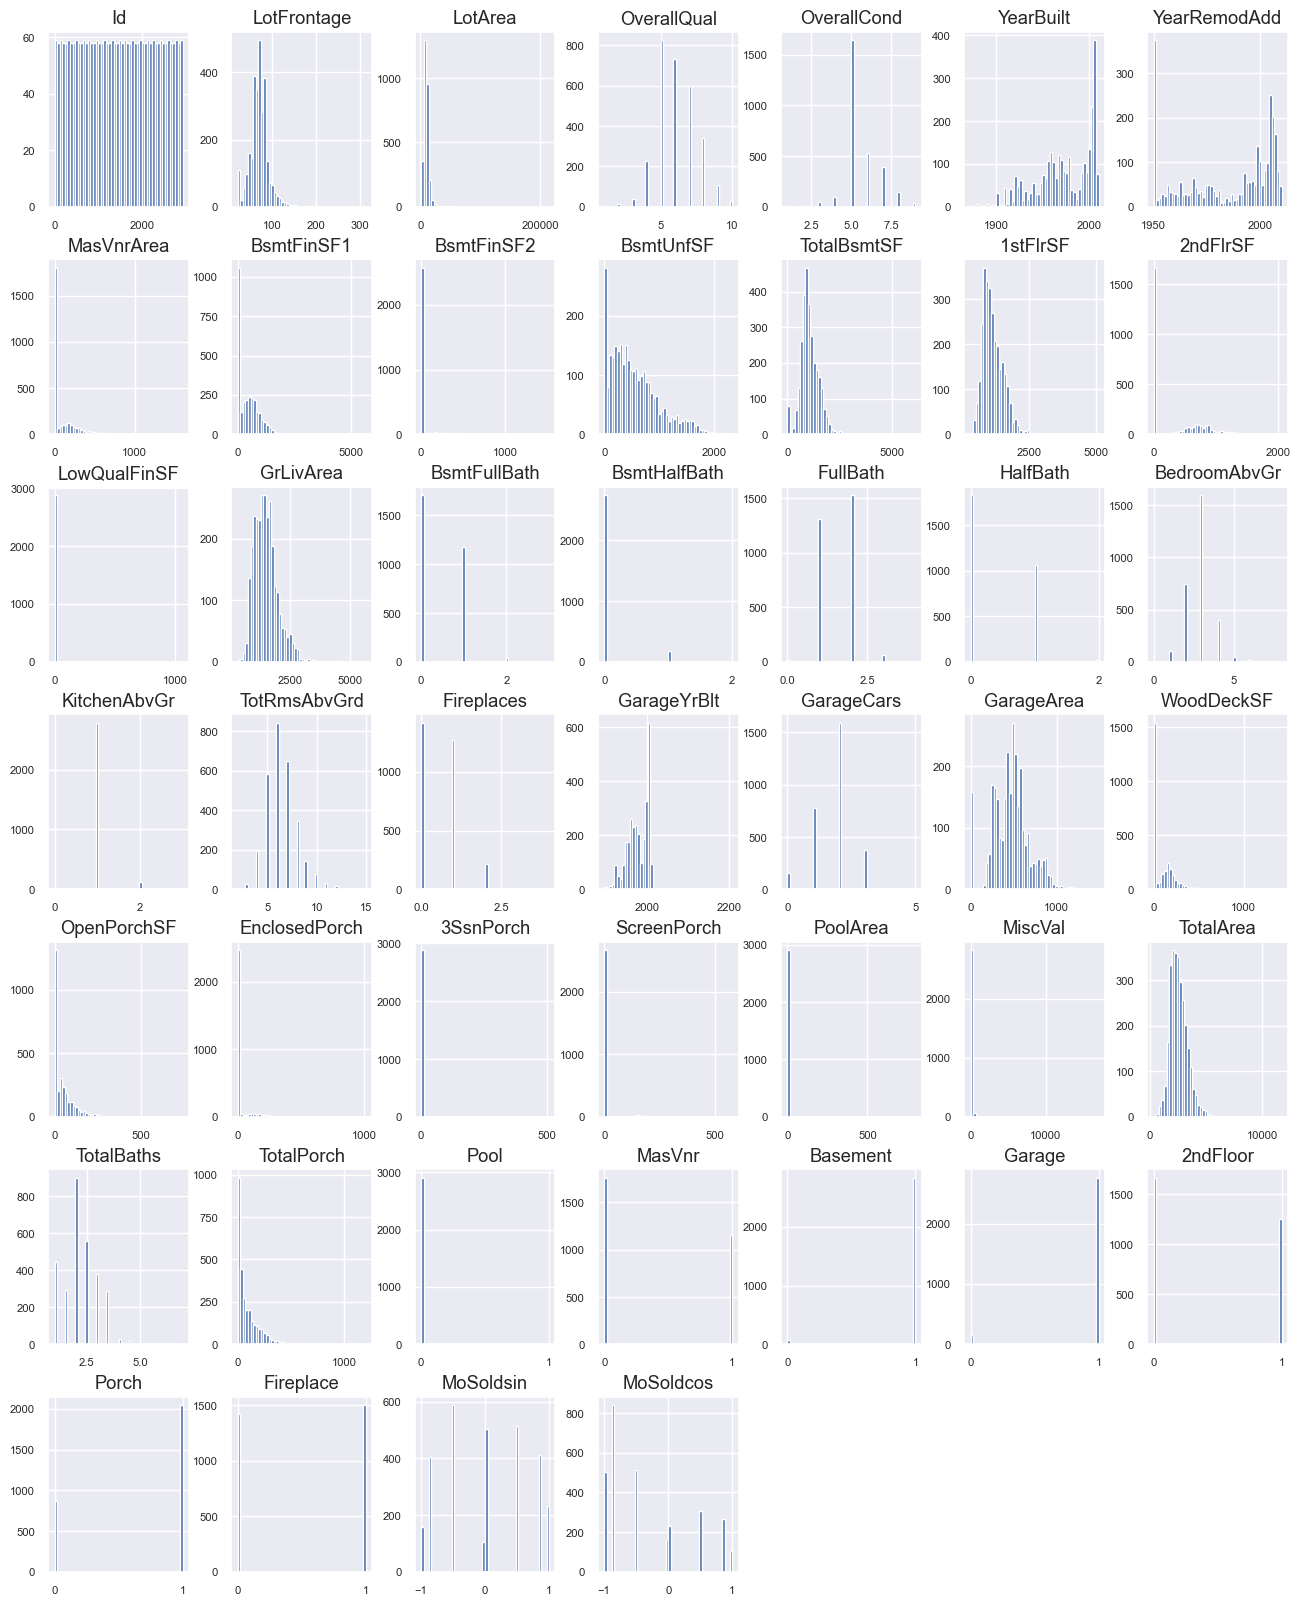

In [23]:
list(set(data.dtypes.tolist()))

df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16,20),bins=50,xlabelsize=8,ylabelsize=8)

On a plusieurs variables qui ne sont pas distribuées normalement
On les normalise

In [ ]:
non_normalize=['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea','GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'LowQualFinSF', 'MiscVal']
non_normal_croiss = np.abs(data[non_normalize].apply(lambda x: skew(x)).sort_values(
    ascending=False))

non_normal_high = non_normal_croiss[non_normal_croiss > 0.3]

non_normal_index = non_normal_high.index

for i in non_normal_index:
    if (data[i] < 0).any():
        print(f"Attention : {i} contient des valeurs négatives !")
    if (data[i] == 0).any():
        print(f"Attention : {i} contient des valeurs nulles !")

for i in non_normal_index:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1)) #Boxcox permet de réduire l'asymétrie de façon efficace

Robust Scaling=> endurcir nos algorithmes face aux valeurs aberrantes

In [24]:

cols = data.select_dtypes(np.number).columns
data[cols] = RobustScaler().fit_transform(data[cols])


Sélection des variables en fonction de leurs importances avec XGB

In [ ]:
from sklearn.feature_selection import SelectFromModel
best_xgb = xgb_search.best_estimator_
# Sélection basée sur l'importance des caractéristiques (exemple avec XGBoost)
selector = SelectFromModel(best_xgb, threshold='median')
selector.fit(X_train, y)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

Encoding

In [25]:
data = pd.get_dummies(data)

On enlève les outliers


In [65]:
X_train = data.iloc[0:1460]  # Indices 0 à 1459 (inclus)
X_test = data.iloc[1460:]    # Indices 1460 à 2918 (inclus)

# Vérification des shapes
print(f"Train shape: {X_train.shape}")  # Doit afficher (1460, n_features)
print(f"Test shape: {X_test.shape}")


Train shape: (1460, 332)
Test shape: (1459, 332)


In [ ]:
print(f"X_train shape: {X_train.shape}") 
print(f"y shape: {y.shape}")  
print(f"Indices de X_train : {X_train.index[:5]}")  
print(f"Indices de y : {y.index[:5]}")
print(f"X_train contient {X_train.duplicated().sum()} doublons")
print(f"y contient {y.isna().sum()} valeurs manquantes")

X_train shape: (2919, 332)
y shape: (2919,)
Indices de X_train : Index([0, 0, 1, 1, 2], dtype='int64')
Indices de y : Index([0, 0, 1, 1, 2], dtype='int64')
X_train contient 0 doublons
y contient 0 valeurs manquantes


In [ ]:
residuals = y - LinearRegression().fit(X_train, y).predict(X_train) #A l'aide d'une régression linéaire simple, on rejette les valeurs des résidus supérieurs à 3
outliers = residuals[np.abs(zscore(residuals)) > 3].index
X_train = X_train.drop(outliers)
y = y.drop(outliers)

Optimisation, Training et Testing

In [29]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
xgb_hpg = {'n_estimators': [100, 400, 800],'max_depth': [3, 6, 9],'learning_rate': [0.05, 0.1, 0.20],'min_child_weight': [1, 10, 100]} #XGBoost
ridge_hpg = {"alpha": np.logspace(-1, 2, 500)} #Ridge Regressor
lasso_hpg = {"alpha": np.logspace(-5, -1, 500)} #Lasso Regressor
svr_hpg = {"C": np.arange(1, 100), "gamma": np.linspace(0.00001, 0.001, 50), "epsilon": np.linspace(0.01, 0.1, 50)} #Support Vector Regressor
lgbm_hpg = {"colsample_bytree": np.linspace(0.2, 0.7, 6), "learning_rate": np.logspace(-3, -1, 100)} #LGBM 
gbm_hpg = {"max_features": np.linspace(0.2, 0.7, 6), "learning_rate": np.logspace(-3, -1, 100)} #Gradient Boost


In [ ]:
#Optimisation de XGB
xgb_model = XGBRegressor()
xgb_search = RandomizedSearchCV(xgb_model, xgb_hpg, n_iter=50, cv=5, scoring='neg_mean_squared_error')
xgb_search.fit(X_train, y)
print("Best XGBoost params:", xgb_search.best_params_)

#Ridge
ridge_model = Ridge()
ridge_search = GridSearchCV(ridge_model, ridge_hpg, cv=5, scoring='neg_mean_squared_error')
ridge_search.fit(X_train, y)
print("Best Ridge params:", ridge_search.best_params_)

#Lasso
lasso_model = Lasso()
lasso_search = GridSearchCV(lasso_model, lasso_hpg, cv=5, scoring='neg_mean_squared_error')
lasso_search.fit(X_train, y)
print("Best Lasso params:", lasso_search.best_params_)

#SVR
svr_model = SVR()
svr_search = RandomizedSearchCV(svr_model, svr_hpg, n_iter=200, cv=5, scoring='neg_mean_squared_error')
svr_search.fit(X_train, y)
print("Best SVR params:", svr_search.best_params_)

#LGBM
lgbm_model = LGBMRegressor()
lgbm_search = RandomizedSearchCV(lgbm_model, lgbm_hpg, n_iter=100, cv=5, scoring='neg_mean_squared_error')
lgbm_search.fit(X_train, y)
print("Best LGBM params:", lgbm_search.best_params_)

#GBM
gbm_model = GradientBoostingRegressor()
gbm_search = RandomizedSearchCV(gbm_model, gbm_hpg, n_iter=100, cv=5, scoring='neg_mean_squared_error')
gbm_search.fit(X_train, y)
print("Best GBM params:", gbm_search.best_params_)



C:\Users\polka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4687
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 253
[LightGBM] [Info] Start training from score 12.024930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

Ensemble Learning Model
We take all the 6 models above, stack them into 1 model and perform Hyper Parameter Tuning

In [ ]:
best_xgb = xgb_search.best_estimator_
best_ridge = ridge_search.best_estimator_
best_lasso = lasso_search.best_estimator_
best_svr = svr_search.best_estimator_
best_lgbm = lgbm_search.best_estimator_
best_gbm = gbm_search.best_estimator_

In [ ]:

base_models = [
    ('xgb', best_xgb),
    ('ridge', best_ridge),
    ('lasso', best_lasso),
    ('svr', best_svr),
    ('lgbm', best_lgbm),
    ('gbm', best_gbm)
    #('nn', nn_model)  # Ajout du réseau de neurones corrigé
]

meta_model = Ridge(alpha = 1)
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_model.fit(X_train, y)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4687
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 253
[LightGBM] [Info] Start training from score 12.024930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                   epsilon=np.float64(0.05040816326530613),
                                   gamma=np.float64(1e-05))),
                              ('lgbm',
                               LGBMRegressor(colsample_bytree=np.float64(0.6),
                                             learning_rate=np.float64(0.008497534359086447),
                                             max_depth=3, n_estimators=2000)),
                              ('gbm',
                               GradientBoostingRegressor(learning_rate=np.float64(0.009770099572992257),
                                                         max_features=np.float64(0.7),
                                                         n_estimators=2000))],
                  final_estimator=Ridge())

Prédiction 

In [ ]:
predictions_log = stacking_model.predict(X_test) #On effectue la prédiction

On repasse à l'exponentielle

In [ ]:
y_pred = np.exp(predictions_log)

In [ ]:
pd.DataFrame({'Id':[i for i in range(1461,2920)], 'SalePrice': y_pred}).to_csv('D:/Ecole/submission_melange4.csv', index = False)
